In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#Loading Data
company = 'FB'

start = dt.datetime(2010,1,1)
end = dt.datetime(2020,1,1)

#data = web.DataReader(company, 'yahoo', start, end)

!pip install yfinance --upgrade --no-cache-dir

from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2020-01-01")

data.head()

#Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days=60

x_train=[]
y_train=[]

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))# Prediction of the next closing value

model.compile(optimizer='adam',loss='mean_squared_error')

print(model.summary())

model.fit(x_train, y_train, epochs=25, batch_size=32)

test_start=dt.datetime(2020,1,1)
test_end=dt.datetime.now()

test_data = pdr.get_data_yahoo("SPY", test_start, test_end)

actual_prices = test_data['Close'].values

total_dataset=pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

"""Make Predictions on Test Data"""

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)



[*********************100%***********************]  1 of 1 completed
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                   

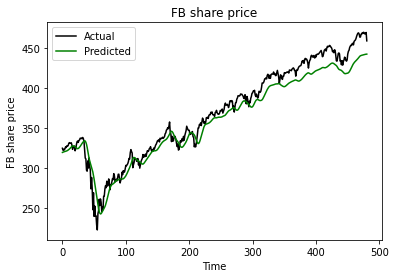

In [3]:
"""plot the test predictions"""

plt.plot(actual_prices, color ='black', label=f"Actual")
plt.plot(predicted_prices, color ='green', label=f"Predicted")
plt.title(f"{company} share price")
plt.xlabel('Time')
plt.ylabel(f"{company} share price")
plt.legend()



In [7]:
"""Predict Next Day"""

real_data = [model_inputs[len(model_inputs)  - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))


In [8]:

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[442.16693]]
